In [1]:
import pandas as pd
import numpy as np
import joblib as jb
import math
import datetime as dt
import seaborn as sns

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)


import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor


from xgboost import XGBRegressor
import xgboost as xgb

from catboost import Pool, CatBoostRegressor

from lightgbm import LGBMRegressor
from lightgbm import plot_importance

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [2]:
def root_mean_squared_error(y_test, preds):
    return math.sqrt(mean_squared_error(y_true=y_test, y_pred=preds))    

### Generate labels

In [3]:
max_labeled_month = 33

total_months_labeled = 10

In [4]:
months_to_predict = [33 - x for x in range(total_months_labeled)]

In [5]:
items = pd.read_csv("cleaned_data/items.csv")
items_categories = pd.read_csv("cleaned_data/item_categories.csv")
sales_train = pd.read_csv("cleaned_data/sales_train.csv")
shops = pd.read_csv("cleaned_data/shops.csv")

In [6]:
df = pd.merge(items, items_categories, on="item_category_id", how="inner")
df = pd.merge(df, sales_train, on="item_id", how="left")
df = pd.merge(df, shops, on="shop_id", how="inner")
df.head()

,item_name,item_id,item_category_id,item_category_name,item_category_type,item_category_subtype,date,date_block_num,shop_id,item_price,item_cnt_day,shop_name,shop_city
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD,Кино,DVD,01.09.2014,20.0,54.0,58.0,1.0,"Химки ТЦ ""Мега""",Химки
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,Кино,DVD,24.08.2014,19.0,54.0,58.0,1.0,"Химки ТЦ ""Мега""",Химки
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,Кино,DVD,12.11.2014,22.0,54.0,58.0,1.0,"Химки ТЦ ""Мега""",Химки
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,Кино,DVD,05.07.2014,18.0,54.0,100.0,1.0,"Химки ТЦ ""Мега""",Химки
4,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,Кино,DVD,26.08.2014,19.0,54.0,58.0,1.0,"Химки ТЦ ""Мега""",Химки


In [7]:
def label_df(df, month_to_label):
    if month_to_label == 34:
        return -1
    
    to_label = df[df["date_block_num"] == month_to_label]
    
    labeled = to_label.groupby(["shop_id", "item_id"]).agg({"item_cnt_day":"sum", "item_category_id":"max", "shop_city":"max"}).reset_index().rename(columns={"item_cnt_day":"label"})
    
    labeled["label"].clip(0, 20, inplace=True)
    
    labeled["labeled_month"] = month_to_label
    
    return labeled

In [8]:
def all_items(labeled_month, sales):
    max_train_month = labeled_month 
    zero_labeled = []
    
    all_items = list(sales[sales.date_block_num == max_train_month]["item_id"].unique()) 
    all_shops = list(sales[sales.date_block_num == max_train_month]["shop_id"].unique())
    
    if labeled_month == 34:
        test = pd.read_csv("cleaned_data/test.csv")
        all_items = list(test["item_id"].unique())
        all_shops = list(test["shop_id"].unique())
    
    zero_labeled = []
    for item_id in all_items:
        for shop_id in all_shops:
            zero_labeled.append([item_id, shop_id])
    
    zero_labeled = pd.DataFrame(zero_labeled, columns=["item_id", "shop_id"])
    zero_labeled = pd.merge(zero_labeled, pd.read_csv("cleaned_data/items.csv"), on="item_id", how="inner")
    zero_labeled = pd.merge(zero_labeled, pd.read_csv("cleaned_data/shops.csv").drop_duplicates(subset=["shop_id"]), on="shop_id", how="inner")
    zero_labeled = zero_labeled[["item_id", "shop_id", "item_category_id", "shop_city"]]
    return zero_labeled

In [9]:
features_folders = ["generated/features_train_" + str(x) + "/" for x in range(1, total_months_labeled + 1)]
dfs_init = []

for x in range(total_months_labeled):
    labeled = label_df(df, max_labeled_month - x)
    all_items_and_shop = all_items(max_labeled_month - x, sales_train)
    labeled = pd.merge(labeled, all_items_and_shop, how="right", on=["item_id", "shop_id", "item_category_id", "shop_city"])
    labeled["label"] = labeled["label"].fillna(0)
    labeled["labeled_month"] = max_labeled_month - x
    labeled = pd.merge(labeled, items_categories, on="item_category_id", how="inner").drop("item_category_name", axis=1)    
    dfs_init.append(labeled)
    print("Labeled: ", max_labeled_month - x, ", len:", len(labeled))

Labeled:  33 , len: 238172
Labeled:  32 , len: 218655
Labeled:  31 , len: 214536
Labeled:  30 , len: 228889
Labeled:  29 , len: 224288
Labeled:  28 , len: 232452
Labeled:  27 , len: 257372
Labeled:  26 , len: 279772
Labeled:  25 , len: 284491
Labeled:  24 , len: 306950


In [10]:
df_test_month = all_items(34, sales_train)
df_test_month = pd.merge(df_test_month, items_categories, on ="item_category_id", how="inner").drop("item_category_name", axis=1)
df_test_month["label"] = -1
df_test_month["labeled_month"] = 34
df_test_month  = df_test_month[['shop_id', 'item_id', 'label', 'item_category_id', 'shop_city', 'labeled_month', 'item_category_type', 'item_category_subtype']]
print(len(df_test_month))
dfs_init.append(df_test_month)
df_test_month.head()

214200


,shop_id,item_id,label,item_category_id,shop_city,labeled_month,item_category_type,item_category_subtype
0,5,5037,-1,19,Вологда,34,Игры,PS3
1,5,5233,-1,19,Вологда,34,Игры,PS3
2,5,4872,-1,19,Вологда,34,Игры,PS3
3,5,5002,-1,19,Вологда,34,Игры,PS3
4,5,5814,-1,19,Вологда,34,Игры,PS3


In [11]:
features_dict = {
    #"features_shop_and_categories.csv":["shop_id", "item_category_id"],
    #"features_categories.csv":"item_category_id",
    #"features_shops.csv":"shop_id",
    "features_items_and_shop.csv": ["item_id", "shop_id"],
    "features_items.csv":"item_id",
    #"features_cities.csv":"shop_city",
    #"features_category_types.csv":"item_category_type",
    #"features_category_subtypes.csv":"item_category_subtype",
    #"features_shop_and_category_types.csv":["shop_id", "item_category_type"]
}

In [12]:
features_folders.append("generated/features_prediction/")
dfs = []
for x in range(len(features_folders)):
    print(x)
    df = dfs_init[x]
    features_folder = features_folders[x]
    print(dfs_init[x]["labeled_month"].max())
    print(features_folder)
    for features_file in features_dict:
        df_features = pd.read_csv(features_folder + features_file)
        joining_cols = features_dict[features_file]
        df = pd.merge(df, df_features, on=joining_cols, how="inner")
        
    print(len(df))
    dfs.append(df)    
print(len(dfs))

0
33
generated/features_train_1/
238172
1
32
generated/features_train_2/
218655
2
31
generated/features_train_3/
214536
3
30
generated/features_train_4/
228889
4
29
generated/features_train_5/
224288
5
28
generated/features_train_6/
232452
6
27
generated/features_train_7/
257372
7
26
generated/features_train_8/
279772
8
25
generated/features_train_9/
284491
9
24
generated/features_train_10/
306950
10
34
generated/features_prediction/
214200
11


In [13]:
df = dfs[0]
for x in range(1, len(dfs)):
    df = df.append(dfs[x])
    
print("Len of train dataframe:", len(df))
df.head()

Len of train dataframe: 2699777


,shop_id,item_id,label,item_category_id,shop_city,labeled_month,item_category_type,item_category_subtype,purchases_item_shop_last_month,purchases_item_in_shop_month_2,purchases_item_in_shop_month_3,month_last_purchase_of_item_in_shop,last_sale_shop_item,hist_sales_mean_item_by_shop,hist_sales_sum_item_by_shop,hist_sales_std_item_by_shop,hist_sales_max_item_by_shop,hist_sales_min_item_by_shop,item_purchases_mean_shifted_1_months,item_purchases_shifted_1_months,item_purchases_max_shifted_1_months,item_purchases_std_shifted_1_months,item_purchases_mean_shifted_2_months,item_purchases_shifted_2_months,item_purchases_max_shifted_2_months,item_purchases_std_shifted_2_months,item_purchases_mean_shifted_3_months,item_purchases_shifted_3_months,item_purchases_max_shifted_3_months,item_purchases_std_shifted_3_months,item_purchases_mean_shifted_6_months,item_purchases_shifted_6_months,item_purchases_max_shifted_6_months,item_purchases_std_shifted_6_months,item_cnt_month_rolling_mean_item,item_cnt_month_rolling_std_item,item_cnt_month_rolling_max_item,item_cnt_month_rolling_min_item,item_cnt_month_diffmean_item
0,2.0,31,1.0,37,Адыгея,33,Кино,Blu,0.0,0.0,0.0,16.0,17.0,0.21875,7.0,0.750672,4.0,0.0,0.209302,9.0,1.0,0.411625,1.261905,53.0,7.0,1.449298,0.139535,6.0,1.0,0.350605,0.276596,13.0,2.0,0.497914,28.833333,47.41322,264.0,7.0,-24.095238
1,6.0,31,2.0,37,Воронеж,33,Кино,Blu,1.0,1.0,0.0,32.0,1.0,1.43750,46.0,3.281792,18.0,0.0,0.209302,9.0,1.0,0.411625,1.261905,53.0,7.0,1.449298,0.139535,6.0,1.0,0.350605,0.276596,13.0,2.0,0.497914,28.833333,47.41322,264.0,7.0,-24.095238
2,18.0,31,1.0,37,Красноярск,33,Кино,Blu,0.0,1.0,0.0,31.0,2.0,1.28125,41.0,3.594210,20.0,0.0,0.209302,9.0,1.0,0.411625,1.261905,53.0,7.0,1.449298,0.139535,6.0,1.0,0.350605,0.276596,13.0,2.0,0.497914,28.833333,47.41322,264.0,7.0,-24.095238
3,21.0,31,1.0,37,Москва,33,Кино,Blu,0.0,1.0,1.0,31.0,2.0,1.21875,39.0,2.684897,14.0,0.0,0.209302,9.0,1.0,0.411625,1.261905,53.0,7.0,1.449298,0.139535,6.0,1.0,0.350605,0.276596,13.0,2.0,0.497914,28.833333,47.41322,264.0,7.0,-24.095238
4,25.0,31,1.0,37,Москва,33,Кино,Blu,0.0,3.0,0.0,31.0,2.0,2.37500,76.0,3.782387,20.0,0.0,0.209302,9.0,1.0,0.411625,1.261905,53.0,7.0,1.449298,0.139535,6.0,1.0,0.350605,0.276596,13.0,2.0,0.497914,28.833333,47.41322,264.0,7.0,-24.095238


#### Analyze and fill na values of dataframe with features

In [14]:
df.isna().sum()

shop_id                                       0
item_id                                       0
label                                         0
item_category_id                              0
shop_city                                     0
labeled_month                                 0
item_category_type                            0
item_category_subtype                         0
purchases_item_shop_last_month           575185
purchases_item_in_shop_month_2           654912
purchases_item_in_shop_month_3           727160
month_last_purchase_of_item_in_shop     1204126
last_sale_shop_item                     1204126
hist_sales_mean_item_by_shop            1233900
hist_sales_sum_item_by_shop             1233900
hist_sales_std_item_by_shop             1315753
hist_sales_max_item_by_shop             1233900
hist_sales_min_item_by_shop             1233900
item_purchases_mean_shifted_1_months     550585
item_purchases_shifted_1_months          550585
item_purchases_max_shifted_1_months     

In [15]:
fill_with_zero_features = ["purchases_item_shop_last_month", "item_cnt_month_rolling_mean_item", "item_cnt_month_rolling_std_item",
                          "item_cnt_month_rolling_max_item", "item_cnt_month_rolling_min_item", "item_cnt_month_diffmean_item"]

for x in range(2,4):
    fill_with_zero_features.append("purchases_item_in_shop_month_" + str(x))

for x in [1,2,3,6]:
    fill_with_zero_features.append("item_purchases_mean_shifted_" + str(x) + "_months")
    fill_with_zero_features.append("item_purchases_max_shifted_" + str(x) + "_months")
    fill_with_zero_features.append("item_purchases_std_shifted_" + str(x) + "_months")
    fill_with_zero_features.append("item_purchases_shifted_" + str(x) + "_months")

for feature in fill_with_zero_features:
    df[feature].fillna(0, inplace=True)
df.sample(10)

,shop_id,item_id,label,item_category_id,shop_city,labeled_month,item_category_type,item_category_subtype,purchases_item_shop_last_month,purchases_item_in_shop_month_2,purchases_item_in_shop_month_3,month_last_purchase_of_item_in_shop,last_sale_shop_item,hist_sales_mean_item_by_shop,hist_sales_sum_item_by_shop,hist_sales_std_item_by_shop,hist_sales_max_item_by_shop,hist_sales_min_item_by_shop,item_purchases_mean_shifted_1_months,item_purchases_shifted_1_months,item_purchases_max_shifted_1_months,item_purchases_std_shifted_1_months,item_purchases_mean_shifted_2_months,item_purchases_shifted_2_months,item_purchases_max_shifted_2_months,item_purchases_std_shifted_2_months,item_purchases_mean_shifted_3_months,item_purchases_shifted_3_months,item_purchases_max_shifted_3_months,item_purchases_std_shifted_3_months,item_purchases_mean_shifted_6_months,item_purchases_shifted_6_months,item_purchases_max_shifted_6_months,item_purchases_std_shifted_6_months,item_cnt_month_rolling_mean_item,item_cnt_month_rolling_std_item,item_cnt_month_rolling_max_item,item_cnt_month_rolling_min_item,item_cnt_month_diffmean_item
86074,56.0,2867,0.0,25,Чехов,27,Игры,Аксессуары для игр,0.0,1.0,0.0,25.0,2.0,NaN,NaN,NaN,NaN,NaN,0.304348,14.0,3.0,0.591404,0.382979,18.0,2.0,0.573062,0.420000,21.0,3.0,0.730949,0.000000,0.0,0.0,0.000000,20.333333,3.771236,23.000000,17.666667,-5.333333
73212,41.0,16729,0.0,40,РостовНаДону,30,Кино,DVD,0.0,0.0,0.0,25.0,5.0,0.384615,5.0,0.767948,2.0,0.0,0.162791,7.0,1.0,0.373544,0.227273,10.0,4.0,0.710834,0.191489,9.0,4.0,0.741277,0.460000,23.0,8.0,1.281103,31.818182,39.433027,140.000000,8.666667,-20.272727
203426,48.0,2317,0.0,31,Томск,31,Игры,Цифра,0.0,0.0,0.0,NaN,NaN,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,1.416667,0.636209,2.666667,1.000000,0.500000
234202,2.0,14203,0.0,31,Адыгея,33,Игры,Цифра,0.0,0.0,0.0,NaN,NaN,0.000000,0.0,0.000000,0.0,0.0,0.069767,3.0,3.0,0.457496,0.000000,0.0,0.0,0.000000,0.046512,2.0,2.0,0.304997,0.021277,1.0,1.0,0.145865,1.750000,0.708140,3.666667,1.000000,0.500000
166819,49.0,15900,0.0,69,Тюмень,32,Подарки,Сувениры,0.0,0.0,0.0,NaN,NaN,0.000000,0.0,0.000000,0.0,0.0,0.190476,8.0,3.0,0.551632,0.279070,12.0,4.0,0.701209,0.023256,1.0,1.0,0.152499,0.000000,0.0,0.0,0.000000,7.000000,0.000000,7.000000,7.000000,3.500000
298335,29.0,6945,0.0,31,Москва,24,Игры,Цифра,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.060000,3.0,3.0,0.424264,0.000000,0.0,0.0,0.000000,0.057692,3.0,3.0,0.416025,0.000000,0.0,0.0,0.000000,2.733333,0.365148,3.333333,2.333333,-0.666667
195449,2.0,17110,0.0,37,Адыгея,24,Кино,Blu,0.0,0.0,0.0,14.0,10.0,NaN,NaN,NaN,NaN,NaN,0.120000,6.0,3.0,0.479796,0.100000,5.0,2.0,0.364216,0.076923,4.0,1.0,0.269069,0.060000,3.0,1.0,0.239898,6.490196,1.889730,10.666667,4.000000,-0.444444
21591,55.0,15751,0.0,37,Цифровой,25,Кино,Blu,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.020000,1.0,1.0,0.141421,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.019608,1.0,1.0,0.140028,1.571429,0.251976,1.666667,1.000000,2.000000
187640,49.0,21441,0.0,38,Тюмень,25,Кино,Blu,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.160000,8.0,2.0,0.421852,0.140000,7.0,3.0,0.495284,0.080000,4.0,1.0,0.274048,0.078431,4.0,1.0,0.271524,11.761905,11.849586,51.666667,2.666667,-5.615385
136206,5.0,8417,1.0,40,Вологда,27,Кино,DVD,0.0,1.0,0.0,25.0,2.0,NaN,NaN,NaN,NaN,NaN,0.434783,20.0,6.0,1.046734,0.382979,18.0,5.0,0.990239,0.660000,33.0,9.0,1.623928,0.000000,0.0,0.0,0.000000,26.000000,2.185813,28.000000,23.666667,-0.750000


In [16]:
df.isna().sum()

shop_id                                       0
item_id                                       0
label                                         0
item_category_id                              0
shop_city                                     0
labeled_month                                 0
item_category_type                            0
item_category_subtype                         0
purchases_item_shop_last_month                0
purchases_item_in_shop_month_2                0
purchases_item_in_shop_month_3                0
month_last_purchase_of_item_in_shop     1204126
last_sale_shop_item                     1204126
hist_sales_mean_item_by_shop            1233900
hist_sales_sum_item_by_shop             1233900
hist_sales_std_item_by_shop             1315753
hist_sales_max_item_by_shop             1233900
hist_sales_min_item_by_shop             1233900
item_purchases_mean_shifted_1_months          0
item_purchases_shifted_1_months               0
item_purchases_max_shifted_1_months     

### Some section to generate label encodings of categorical variables

In [17]:
df["item_cat+shop"] = df["item_category_id"].apply(str) + "_" + df["shop_id"].apply(str)
df["item+shop"] = df["item_id"].apply(str) + "_" + df["shop_id"].apply(str)

#### Label encode item_cat+shop && item+shop

In [18]:
df["item_cat+shop"] = df["item_cat+shop"].astype(str).apply(lambda x: x[:-2])
df["item+shop"] = df["item+shop"].astype(str).apply(lambda x: x[:-2])

df.head()

,shop_id,item_id,label,item_category_id,shop_city,labeled_month,item_category_type,item_category_subtype,purchases_item_shop_last_month,purchases_item_in_shop_month_2,purchases_item_in_shop_month_3,month_last_purchase_of_item_in_shop,last_sale_shop_item,hist_sales_mean_item_by_shop,hist_sales_sum_item_by_shop,hist_sales_std_item_by_shop,hist_sales_max_item_by_shop,hist_sales_min_item_by_shop,item_purchases_mean_shifted_1_months,item_purchases_shifted_1_months,item_purchases_max_shifted_1_months,item_purchases_std_shifted_1_months,item_purchases_mean_shifted_2_months,item_purchases_shifted_2_months,item_purchases_max_shifted_2_months,item_purchases_std_shifted_2_months,item_purchases_mean_shifted_3_months,item_purchases_shifted_3_months,item_purchases_max_shifted_3_months,item_purchases_std_shifted_3_months,item_purchases_mean_shifted_6_months,item_purchases_shifted_6_months,item_purchases_max_shifted_6_months,item_purchases_std_shifted_6_months,item_cnt_month_rolling_mean_item,item_cnt_month_rolling_std_item,item_cnt_month_rolling_max_item,item_cnt_month_rolling_min_item,item_cnt_month_diffmean_item,item_cat+shop,item+shop
0,2.0,31,1.0,37,Адыгея,33,Кино,Blu,0.0,0.0,0.0,16.0,17.0,0.21875,7.0,0.750672,4.0,0.0,0.209302,9.0,1.0,0.411625,1.261905,53.0,7.0,1.449298,0.139535,6.0,1.0,0.350605,0.276596,13.0,2.0,0.497914,28.833333,47.41322,264.0,7.0,-24.095238,37_2,31_2
1,6.0,31,2.0,37,Воронеж,33,Кино,Blu,1.0,1.0,0.0,32.0,1.0,1.43750,46.0,3.281792,18.0,0.0,0.209302,9.0,1.0,0.411625,1.261905,53.0,7.0,1.449298,0.139535,6.0,1.0,0.350605,0.276596,13.0,2.0,0.497914,28.833333,47.41322,264.0,7.0,-24.095238,37_6,31_6
2,18.0,31,1.0,37,Красноярск,33,Кино,Blu,0.0,1.0,0.0,31.0,2.0,1.28125,41.0,3.594210,20.0,0.0,0.209302,9.0,1.0,0.411625,1.261905,53.0,7.0,1.449298,0.139535,6.0,1.0,0.350605,0.276596,13.0,2.0,0.497914,28.833333,47.41322,264.0,7.0,-24.095238,37_18,31_18
3,21.0,31,1.0,37,Москва,33,Кино,Blu,0.0,1.0,1.0,31.0,2.0,1.21875,39.0,2.684897,14.0,0.0,0.209302,9.0,1.0,0.411625,1.261905,53.0,7.0,1.449298,0.139535,6.0,1.0,0.350605,0.276596,13.0,2.0,0.497914,28.833333,47.41322,264.0,7.0,-24.095238,37_21,31_21
4,25.0,31,1.0,37,Москва,33,Кино,Blu,0.0,3.0,0.0,31.0,2.0,2.37500,76.0,3.782387,20.0,0.0,0.209302,9.0,1.0,0.411625,1.261905,53.0,7.0,1.449298,0.139535,6.0,1.0,0.350605,0.276596,13.0,2.0,0.497914,28.833333,47.41322,264.0,7.0,-24.095238,37_25,31_25


In [19]:
item_cat_shop_le = LabelEncoder()

item_cat_shop_le.fit(df["item_cat+shop"])

df["item_cat+shop"] = item_cat_shop_le.transform(df["item_cat+shop"])

df.head()

,shop_id,item_id,label,item_category_id,shop_city,labeled_month,item_category_type,item_category_subtype,purchases_item_shop_last_month,purchases_item_in_shop_month_2,purchases_item_in_shop_month_3,month_last_purchase_of_item_in_shop,last_sale_shop_item,hist_sales_mean_item_by_shop,hist_sales_sum_item_by_shop,hist_sales_std_item_by_shop,hist_sales_max_item_by_shop,hist_sales_min_item_by_shop,item_purchases_mean_shifted_1_months,item_purchases_shifted_1_months,item_purchases_max_shifted_1_months,item_purchases_std_shifted_1_months,item_purchases_mean_shifted_2_months,item_purchases_shifted_2_months,item_purchases_max_shifted_2_months,item_purchases_std_shifted_2_months,item_purchases_mean_shifted_3_months,item_purchases_shifted_3_months,item_purchases_max_shifted_3_months,item_purchases_std_shifted_3_months,item_purchases_mean_shifted_6_months,item_purchases_shifted_6_months,item_purchases_max_shifted_6_months,item_purchases_std_shifted_6_months,item_cnt_month_rolling_mean_item,item_cnt_month_rolling_std_item,item_cnt_month_rolling_max_item,item_cnt_month_rolling_min_item,item_cnt_month_diffmean_item,item_cat+shop,item+shop
0,2.0,31,1.0,37,Адыгея,33,Кино,Blu,0.0,0.0,0.0,16.0,17.0,0.21875,7.0,0.750672,4.0,0.0,0.209302,9.0,1.0,0.411625,1.261905,53.0,7.0,1.449298,0.139535,6.0,1.0,0.350605,0.276596,13.0,2.0,0.497914,28.833333,47.41322,264.0,7.0,-24.095238,1382,31_2
1,6.0,31,2.0,37,Воронеж,33,Кино,Blu,1.0,1.0,0.0,32.0,1.0,1.43750,46.0,3.281792,18.0,0.0,0.209302,9.0,1.0,0.411625,1.261905,53.0,7.0,1.449298,0.139535,6.0,1.0,0.350605,0.276596,13.0,2.0,0.497914,28.833333,47.41322,264.0,7.0,-24.095238,1424,31_6
2,18.0,31,1.0,37,Красноярск,33,Кино,Blu,0.0,1.0,0.0,31.0,2.0,1.28125,41.0,3.594210,20.0,0.0,0.209302,9.0,1.0,0.411625,1.261905,53.0,7.0,1.449298,0.139535,6.0,1.0,0.350605,0.276596,13.0,2.0,0.497914,28.833333,47.41322,264.0,7.0,-24.095238,1380,31_18
3,21.0,31,1.0,37,Москва,33,Кино,Blu,0.0,1.0,1.0,31.0,2.0,1.21875,39.0,2.684897,14.0,0.0,0.209302,9.0,1.0,0.411625,1.261905,53.0,7.0,1.449298,0.139535,6.0,1.0,0.350605,0.276596,13.0,2.0,0.497914,28.833333,47.41322,264.0,7.0,-24.095238,1384,31_21
4,25.0,31,1.0,37,Москва,33,Кино,Blu,0.0,3.0,0.0,31.0,2.0,2.37500,76.0,3.782387,20.0,0.0,0.209302,9.0,1.0,0.411625,1.261905,53.0,7.0,1.449298,0.139535,6.0,1.0,0.350605,0.276596,13.0,2.0,0.497914,28.833333,47.41322,264.0,7.0,-24.095238,1387,31_25


In [20]:
item_shop_le = LabelEncoder()

item_shop_le.fit(df["item+shop"])

df["item+shop"] = item_shop_le.transform(df["item+shop"])

df.head()

,shop_id,item_id,label,item_category_id,shop_city,labeled_month,item_category_type,item_category_subtype,purchases_item_shop_last_month,purchases_item_in_shop_month_2,purchases_item_in_shop_month_3,month_last_purchase_of_item_in_shop,last_sale_shop_item,hist_sales_mean_item_by_shop,hist_sales_sum_item_by_shop,hist_sales_std_item_by_shop,hist_sales_max_item_by_shop,hist_sales_min_item_by_shop,item_purchases_mean_shifted_1_months,item_purchases_shifted_1_months,item_purchases_max_shifted_1_months,item_purchases_std_shifted_1_months,item_purchases_mean_shifted_2_months,item_purchases_shifted_2_months,item_purchases_max_shifted_2_months,item_purchases_std_shifted_2_months,item_purchases_mean_shifted_3_months,item_purchases_shifted_3_months,item_purchases_max_shifted_3_months,item_purchases_std_shifted_3_months,item_purchases_mean_shifted_6_months,item_purchases_shifted_6_months,item_purchases_max_shifted_6_months,item_purchases_std_shifted_6_months,item_cnt_month_rolling_mean_item,item_cnt_month_rolling_std_item,item_cnt_month_rolling_max_item,item_cnt_month_rolling_min_item,item_cnt_month_diffmean_item,item_cat+shop,item+shop
0,2.0,31,1.0,37,Адыгея,33,Кино,Blu,0.0,0.0,0.0,16.0,17.0,0.21875,7.0,0.750672,4.0,0.0,0.209302,9.0,1.0,0.411625,1.261905,53.0,7.0,1.449298,0.139535,6.0,1.0,0.350605,0.276596,13.0,2.0,0.497914,28.833333,47.41322,264.0,7.0,-24.095238,1382,383369
1,6.0,31,2.0,37,Воронеж,33,Кино,Blu,1.0,1.0,0.0,32.0,1.0,1.43750,46.0,3.281792,18.0,0.0,0.209302,9.0,1.0,0.411625,1.261905,53.0,7.0,1.449298,0.139535,6.0,1.0,0.350605,0.276596,13.0,2.0,0.497914,28.833333,47.41322,264.0,7.0,-24.095238,1424,383411
2,18.0,31,1.0,37,Красноярск,33,Кино,Blu,0.0,1.0,0.0,31.0,2.0,1.28125,41.0,3.594210,20.0,0.0,0.209302,9.0,1.0,0.411625,1.261905,53.0,7.0,1.449298,0.139535,6.0,1.0,0.350605,0.276596,13.0,2.0,0.497914,28.833333,47.41322,264.0,7.0,-24.095238,1380,383367
3,21.0,31,1.0,37,Москва,33,Кино,Blu,0.0,1.0,1.0,31.0,2.0,1.21875,39.0,2.684897,14.0,0.0,0.209302,9.0,1.0,0.411625,1.261905,53.0,7.0,1.449298,0.139535,6.0,1.0,0.350605,0.276596,13.0,2.0,0.497914,28.833333,47.41322,264.0,7.0,-24.095238,1384,383371
4,25.0,31,1.0,37,Москва,33,Кино,Blu,0.0,3.0,0.0,31.0,2.0,2.37500,76.0,3.782387,20.0,0.0,0.209302,9.0,1.0,0.411625,1.261905,53.0,7.0,1.449298,0.139535,6.0,1.0,0.350605,0.276596,13.0,2.0,0.497914,28.833333,47.41322,264.0,7.0,-24.095238,1387,383374


#### Label encode item categories aspects

In [21]:
item_category_type_encoder = LabelEncoder()

item_category_type_encoder.fit(df["item_category_type"])

df["item_category_type"] = item_category_type_encoder.transform(df["item_category_type"])

df.head()

,shop_id,item_id,label,item_category_id,shop_city,labeled_month,item_category_type,item_category_subtype,purchases_item_shop_last_month,purchases_item_in_shop_month_2,purchases_item_in_shop_month_3,month_last_purchase_of_item_in_shop,last_sale_shop_item,hist_sales_mean_item_by_shop,hist_sales_sum_item_by_shop,hist_sales_std_item_by_shop,hist_sales_max_item_by_shop,hist_sales_min_item_by_shop,item_purchases_mean_shifted_1_months,item_purchases_shifted_1_months,item_purchases_max_shifted_1_months,item_purchases_std_shifted_1_months,item_purchases_mean_shifted_2_months,item_purchases_shifted_2_months,item_purchases_max_shifted_2_months,item_purchases_std_shifted_2_months,item_purchases_mean_shifted_3_months,item_purchases_shifted_3_months,item_purchases_max_shifted_3_months,item_purchases_std_shifted_3_months,item_purchases_mean_shifted_6_months,item_purchases_shifted_6_months,item_purchases_max_shifted_6_months,item_purchases_std_shifted_6_months,item_cnt_month_rolling_mean_item,item_cnt_month_rolling_std_item,item_cnt_month_rolling_max_item,item_cnt_month_rolling_min_item,item_cnt_month_diffmean_item,item_cat+shop,item+shop
0,2.0,31,1.0,37,Адыгея,33,7,Blu,0.0,0.0,0.0,16.0,17.0,0.21875,7.0,0.750672,4.0,0.0,0.209302,9.0,1.0,0.411625,1.261905,53.0,7.0,1.449298,0.139535,6.0,1.0,0.350605,0.276596,13.0,2.0,0.497914,28.833333,47.41322,264.0,7.0,-24.095238,1382,383369
1,6.0,31,2.0,37,Воронеж,33,7,Blu,1.0,1.0,0.0,32.0,1.0,1.43750,46.0,3.281792,18.0,0.0,0.209302,9.0,1.0,0.411625,1.261905,53.0,7.0,1.449298,0.139535,6.0,1.0,0.350605,0.276596,13.0,2.0,0.497914,28.833333,47.41322,264.0,7.0,-24.095238,1424,383411
2,18.0,31,1.0,37,Красноярск,33,7,Blu,0.0,1.0,0.0,31.0,2.0,1.28125,41.0,3.594210,20.0,0.0,0.209302,9.0,1.0,0.411625,1.261905,53.0,7.0,1.449298,0.139535,6.0,1.0,0.350605,0.276596,13.0,2.0,0.497914,28.833333,47.41322,264.0,7.0,-24.095238,1380,383367
3,21.0,31,1.0,37,Москва,33,7,Blu,0.0,1.0,1.0,31.0,2.0,1.21875,39.0,2.684897,14.0,0.0,0.209302,9.0,1.0,0.411625,1.261905,53.0,7.0,1.449298,0.139535,6.0,1.0,0.350605,0.276596,13.0,2.0,0.497914,28.833333,47.41322,264.0,7.0,-24.095238,1384,383371
4,25.0,31,1.0,37,Москва,33,7,Blu,0.0,3.0,0.0,31.0,2.0,2.37500,76.0,3.782387,20.0,0.0,0.209302,9.0,1.0,0.411625,1.261905,53.0,7.0,1.449298,0.139535,6.0,1.0,0.350605,0.276596,13.0,2.0,0.497914,28.833333,47.41322,264.0,7.0,-24.095238,1387,383374


In [22]:
item_category_subtype_encoder = LabelEncoder()

item_category_subtype_encoder.fit(df["item_category_subtype"])

df["item_category_subtype"] = item_category_subtype_encoder.transform(df["item_category_subtype"])

df.head()

,shop_id,item_id,label,item_category_id,shop_city,labeled_month,item_category_type,item_category_subtype,purchases_item_shop_last_month,purchases_item_in_shop_month_2,purchases_item_in_shop_month_3,month_last_purchase_of_item_in_shop,last_sale_shop_item,hist_sales_mean_item_by_shop,hist_sales_sum_item_by_shop,hist_sales_std_item_by_shop,hist_sales_max_item_by_shop,hist_sales_min_item_by_shop,item_purchases_mean_shifted_1_months,item_purchases_shifted_1_months,item_purchases_max_shifted_1_months,item_purchases_std_shifted_1_months,item_purchases_mean_shifted_2_months,item_purchases_shifted_2_months,item_purchases_max_shifted_2_months,item_purchases_std_shifted_2_months,item_purchases_mean_shifted_3_months,item_purchases_shifted_3_months,item_purchases_max_shifted_3_months,item_purchases_std_shifted_3_months,item_purchases_mean_shifted_6_months,item_purchases_shifted_6_months,item_purchases_max_shifted_6_months,item_purchases_std_shifted_6_months,item_cnt_month_rolling_mean_item,item_cnt_month_rolling_std_item,item_cnt_month_rolling_max_item,item_cnt_month_rolling_min_item,item_cnt_month_diffmean_item,item_cat+shop,item+shop
0,2.0,31,1.0,37,Адыгея,33,7,1,0.0,0.0,0.0,16.0,17.0,0.21875,7.0,0.750672,4.0,0.0,0.209302,9.0,1.0,0.411625,1.261905,53.0,7.0,1.449298,0.139535,6.0,1.0,0.350605,0.276596,13.0,2.0,0.497914,28.833333,47.41322,264.0,7.0,-24.095238,1382,383369
1,6.0,31,2.0,37,Воронеж,33,7,1,1.0,1.0,0.0,32.0,1.0,1.43750,46.0,3.281792,18.0,0.0,0.209302,9.0,1.0,0.411625,1.261905,53.0,7.0,1.449298,0.139535,6.0,1.0,0.350605,0.276596,13.0,2.0,0.497914,28.833333,47.41322,264.0,7.0,-24.095238,1424,383411
2,18.0,31,1.0,37,Красноярск,33,7,1,0.0,1.0,0.0,31.0,2.0,1.28125,41.0,3.594210,20.0,0.0,0.209302,9.0,1.0,0.411625,1.261905,53.0,7.0,1.449298,0.139535,6.0,1.0,0.350605,0.276596,13.0,2.0,0.497914,28.833333,47.41322,264.0,7.0,-24.095238,1380,383367
3,21.0,31,1.0,37,Москва,33,7,1,0.0,1.0,1.0,31.0,2.0,1.21875,39.0,2.684897,14.0,0.0,0.209302,9.0,1.0,0.411625,1.261905,53.0,7.0,1.449298,0.139535,6.0,1.0,0.350605,0.276596,13.0,2.0,0.497914,28.833333,47.41322,264.0,7.0,-24.095238,1384,383371
4,25.0,31,1.0,37,Москва,33,7,1,0.0,3.0,0.0,31.0,2.0,2.37500,76.0,3.782387,20.0,0.0,0.209302,9.0,1.0,0.411625,1.261905,53.0,7.0,1.449298,0.139535,6.0,1.0,0.350605,0.276596,13.0,2.0,0.497914,28.833333,47.41322,264.0,7.0,-24.095238,1387,383374


#### Label encode shop city

In [23]:
shop_city_encoder = LabelEncoder()

shop_city_encoder.fit(df["shop_city"])

df["shop_city"] = shop_city_encoder.transform(df["shop_city"])

df.head()

,shop_id,item_id,label,item_category_id,shop_city,labeled_month,item_category_type,item_category_subtype,purchases_item_shop_last_month,purchases_item_in_shop_month_2,purchases_item_in_shop_month_3,month_last_purchase_of_item_in_shop,last_sale_shop_item,hist_sales_mean_item_by_shop,hist_sales_sum_item_by_shop,hist_sales_std_item_by_shop,hist_sales_max_item_by_shop,hist_sales_min_item_by_shop,item_purchases_mean_shifted_1_months,item_purchases_shifted_1_months,item_purchases_max_shifted_1_months,item_purchases_std_shifted_1_months,item_purchases_mean_shifted_2_months,item_purchases_shifted_2_months,item_purchases_max_shifted_2_months,item_purchases_std_shifted_2_months,item_purchases_mean_shifted_3_months,item_purchases_shifted_3_months,item_purchases_max_shifted_3_months,item_purchases_std_shifted_3_months,item_purchases_mean_shifted_6_months,item_purchases_shifted_6_months,item_purchases_max_shifted_6_months,item_purchases_std_shifted_6_months,item_cnt_month_rolling_mean_item,item_cnt_month_rolling_std_item,item_cnt_month_rolling_max_item,item_cnt_month_rolling_min_item,item_cnt_month_diffmean_item,item_cat+shop,item+shop
0,2.0,31,1.0,37,0,33,7,1,0.0,0.0,0.0,16.0,17.0,0.21875,7.0,0.750672,4.0,0.0,0.209302,9.0,1.0,0.411625,1.261905,53.0,7.0,1.449298,0.139535,6.0,1.0,0.350605,0.276596,13.0,2.0,0.497914,28.833333,47.41322,264.0,7.0,-24.095238,1382,383369
1,6.0,31,2.0,37,4,33,7,1,1.0,1.0,0.0,32.0,1.0,1.43750,46.0,3.281792,18.0,0.0,0.209302,9.0,1.0,0.411625,1.261905,53.0,7.0,1.449298,0.139535,6.0,1.0,0.350605,0.276596,13.0,2.0,0.497914,28.833333,47.41322,264.0,7.0,-24.095238,1424,383411
2,18.0,31,1.0,37,11,33,7,1,0.0,1.0,0.0,31.0,2.0,1.28125,41.0,3.594210,20.0,0.0,0.209302,9.0,1.0,0.411625,1.261905,53.0,7.0,1.449298,0.139535,6.0,1.0,0.350605,0.276596,13.0,2.0,0.497914,28.833333,47.41322,264.0,7.0,-24.095238,1380,383367
3,21.0,31,1.0,37,13,33,7,1,0.0,1.0,1.0,31.0,2.0,1.21875,39.0,2.684897,14.0,0.0,0.209302,9.0,1.0,0.411625,1.261905,53.0,7.0,1.449298,0.139535,6.0,1.0,0.350605,0.276596,13.0,2.0,0.497914,28.833333,47.41322,264.0,7.0,-24.095238,1384,383371
4,25.0,31,1.0,37,13,33,7,1,0.0,3.0,0.0,31.0,2.0,2.37500,76.0,3.782387,20.0,0.0,0.209302,9.0,1.0,0.411625,1.261905,53.0,7.0,1.449298,0.139535,6.0,1.0,0.350605,0.276596,13.0,2.0,0.497914,28.833333,47.41322,264.0,7.0,-24.095238,1387,383374


### Final preparations

In [24]:
features = df.copy()
for feature in features.columns:
    features[feature] = features[feature].values.astype(int)

In [25]:
target_col = "label"

predictors = [x for x in features.columns if x not in target_col]

print("Predictors are:", predictors)

Predictors are: ['shop_id', 'item_id', 'item_category_id', 'shop_city', 'labeled_month', 'item_category_type', 'item_category_subtype', 'purchases_item_shop_last_month', 'purchases_item_in_shop_month_2', 'purchases_item_in_shop_month_3', 'month_last_purchase_of_item_in_shop', 'last_sale_shop_item', 'hist_sales_mean_item_by_shop', 'hist_sales_sum_item_by_shop', 'hist_sales_std_item_by_shop', 'hist_sales_max_item_by_shop', 'hist_sales_min_item_by_shop', 'item_purchases_mean_shifted_1_months', 'item_purchases_shifted_1_months', 'item_purchases_max_shifted_1_months', 'item_purchases_std_shifted_1_months', 'item_purchases_mean_shifted_2_months', 'item_purchases_shifted_2_months', 'item_purchases_max_shifted_2_months', 'item_purchases_std_shifted_2_months', 'item_purchases_mean_shifted_3_months', 'item_purchases_shifted_3_months', 'item_purchases_max_shifted_3_months', 'item_purchases_std_shifted_3_months', 'item_purchases_mean_shifted_6_months', 'item_purchases_shifted_6_months', 'item_purc

In [27]:
X_train = features[features.labeled_month <= 33][predictors]
y_train = features[features.labeled_month <= 33][target_col].clip(0, 20)
#X_val = features[features.labeled_month == 33][predictors]
#y_val = features[features.labeled_month == 33][target_col].clip(0, 20)
X_test = features[features.labeled_month == 34][predictors]

print("Train size:", len(X_train))
#print("Validation size:", len(X_val))
print("Test size", len(X_test))

Train size: 2485577
Test size 214200


## Run until here to process dataframe. Now, go to specific model. 

## XGBOOST

### Tuning algorithm grid searching

In [ ]:
def fit_model(xgb_estimator, dataframe_train, predictors_cols, target_col, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        params = xgb_estimator.get_xgb_params()
        xgb_train_matrix = xgb.DMatrix(dataframe_train[predictors_cols].values, label=dataframe_train[target_col].values)
        cvresult = xgb.cv(params, xgb_train_matrix, num_boost_round=xgb_estimator.get_params()['n_estimators'], nfold=cv_folds,
            metrics='rmse', early_stopping_rounds=early_stopping_rounds)
        xgb_estimator.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    xgb_estimator.fit(dataframe_train[predictors_cols], dataframe_train[target_col], eval_metric='rmse')
        
    #Predict training set:
    train_prediction = xgb_estimator.predict(dataframe_train[predictors])
        
    #Print model report:
    print("\nModel Report") 
    print("RMSE :", root_mean_squared_error(dataframe_train[target_col].values, train_prediction))
                    
    feat_imp = pd.Series(xgb_estimator.get_booster().get_score(importance_type='weight')).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

### Get n_estimators

In [ ]:
target_col = "label"

predictors = [x for x in features.columns if x not in target_col]

print("Predictors are:", predictors)

xgboost_n_estimators = XGBRegressor(
 learning_rate=0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective='reg:squarederror',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

fit_model(xgboost_n_estimators, features, predictors, target_col)

In [ ]:
optimal_n_estimators = xgboost_n_estimators.n_estimators
optimal_n_estimators

### Tune max_depth and min_child_weight

In [ ]:
params_1 = {
 'max_depth':range(6,16,2),
 'min_child_weight':range(1,6,2)
}

In [ ]:
grid_search_1 = GridSearchCV(estimator=XGBRegressor(
        learning_rate=0.1,
        n_estimators=optimal_n_estimators,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'reg:squarederror',
        nthread=4,
        scale_pos_weight=1,
        seed=27), param_grid=params_1, scoring='neg_mean_squared_error', n_jobs=4)

In [ ]:
grid_search_1.fit(X_train, y_train)

In [ ]:
grid_search_1.best_estimator_

In [ ]:
optimal_max_depth = 5
optimal_min_child_weight = 1

### Tune gamma

In [ ]:
params_2 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

In [ ]:
grid_search_2 = GridSearchCV(estimator=XGBRegressor(
        learning_rate=0.1,
        n_estimators=optimal_n_estimators,
        max_depth=optimal_max_depth,
        min_child_weight=optimal_min_child_weight,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'reg:squarederror',
        nthread=4,
        scale_pos_weight=1,
        seed=27), param_grid=params_2, scoring='neg_mean_squared_error', n_jobs=4)

In [ ]:
grid_search_2.fit(X_train, y_train)

In [ ]:
grid_search_2.best_estimator_

In [ ]:
optimal_gamma = 0

### Tune subsample and colsample_by_tree

In [ ]:
params_3 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

In [ ]:
grid_search_3 = GridSearchCV(estimator=XGBRegressor(
        learning_rate=0.1,
        n_estimators=optimal_n_estimators,
        max_depth=optimal_max_depth,
        min_child_weight=optimal_min_child_weight,
        objective= 'reg:squarederror',
        nthread=4,
        scale_pos_weight=1,
        gamma=optimal_gamma,
        seed=27), param_grid=params_3, scoring='neg_mean_squared_error', n_jobs=4)

In [ ]:
grid_search_3.fit(X_train, y_train)

In [ ]:
grid_search_3.best_estimator_

In [ ]:
optimal_subsample = 0.9
optimal_colsample_by_tree = 0.7

In [ ]:
optimal_parameters = {
    "n_estimators": optimal_n_estimators,
    "max_depth": optimal_max_depth,
    "min_child_weight": optimal_min_child_weight,
    "gamma": optimal_gamma,
    "subsample": optimal_subsample,
    "colsample_by_tree": optimal_colsample_by_tree
}

optimal_parameters

In [ ]:
jb.dump(optimal_parameters, "model_parameters/xgb_parameters.pkl")

### Train

In [28]:
xgboost = XGBRegressor(max_depth = 11, min_child_weight=0.5, subsample = 1, eta = 0.3, num_round = 1000, seed = 1, nthread = 16)

In [30]:
a = dt.datetime.now()

xgboost.fit(X_train, y_train, verbose=True)#, eval_set=[(X_val, y_val)], eval_metric="rmse")

b = dt.datetime.now()

c = b - a
time = divmod(c.seconds, 60)

print("Transcurred time: ", time[0], ":", time[1])

[20:11:04] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Transcurred time:  9 : 3


In [31]:
preds_train = xgboost.predict(X_train)

In [32]:
root_mean_squared_error(y_train, preds_train)

0.5953835088602494

In [35]:
test_predictions = xgboost.predict(X_val)

In [36]:
root_mean_squared_error(y_val, test_predictions)

0.9748663175926485

In [33]:
jb.dump(xgboost, "new-models/XGB-29.pkl")

['new-models/XGB-29.pkl']

Text(0, 0.5, 'Feature Importance Score')

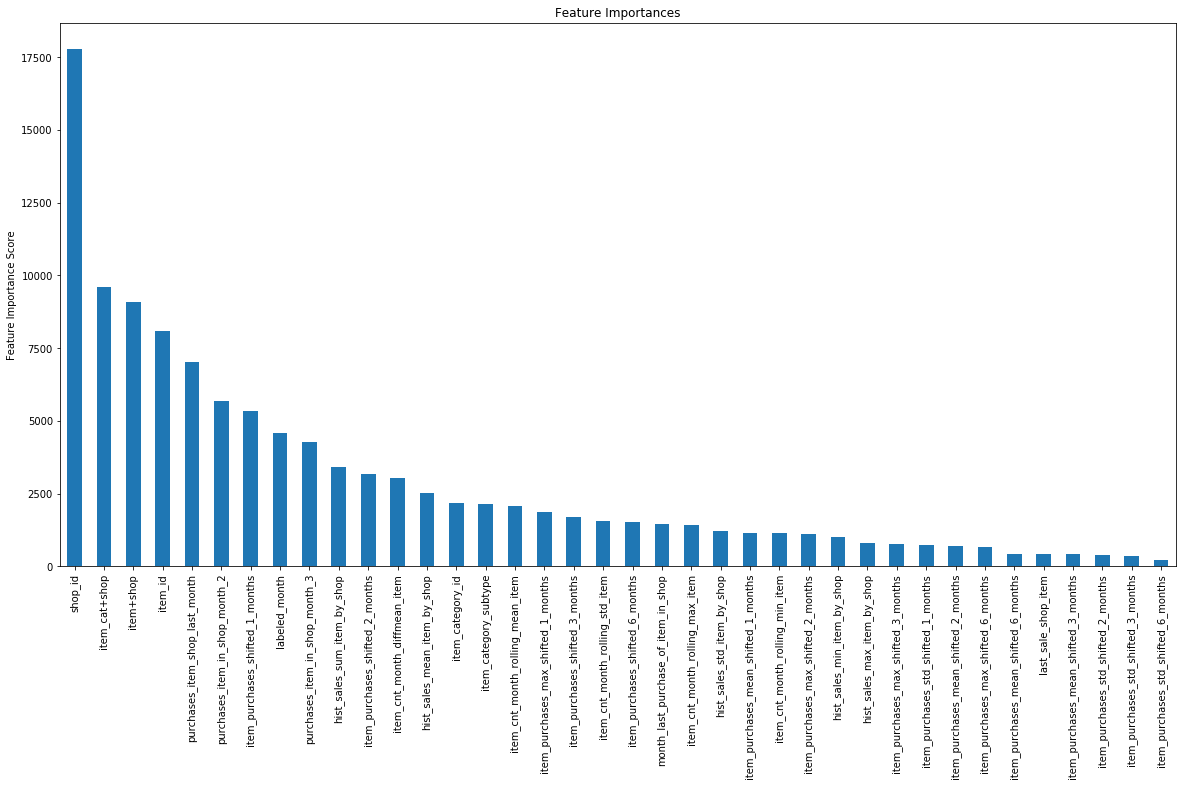

In [34]:
plt.figure(figsize=(20,10))
feat_imp = pd.Series(xgboost.get_booster().get_score(importance_type='weight')).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [37]:
X_test["item_cnt_month"] = xgboost.predict(X_test).clip(0, 20)

## LIGHTGBM

In [49]:
lgbm = LGBMRegressor(
 learning_rate=0.03,
 n_estimators=1000,
 max_depth=10,
 boosting_type='gbdt' ,
 subsample=0.9,
 objective='regression',
 colsample_bytree=0.7,
 min_child_weight=1,   
 njobs=4,
 scale_pos_weight=1,   
 random_state=27,
 silent=False)

In [50]:
X_train.head()

,shop_id,item_id,item_category_id,shop_city,labeled_month,item_category_type,item_category_subtype,purchases_item_shop_last_month,purchases_item_in_shop_month_2,purchases_item_in_shop_month_3,month_last_purchase_of_item_in_shop,last_sale_shop_item,item_purchases_mean_shifted_1_months,item_purchases_shifted_1_months,item_purchases_max_shifted_1_months,item_purchases_std_shifted_1_months,item_purchases_mean_shifted_2_months,item_purchases_shifted_2_months,item_purchases_max_shifted_2_months,item_purchases_std_shifted_2_months,item_purchases_mean_shifted_3_months,item_purchases_shifted_3_months,item_purchases_max_shifted_3_months,item_purchases_std_shifted_3_months,item_purchases_mean_shifted_6_months,item_purchases_shifted_6_months,item_purchases_max_shifted_6_months,item_purchases_std_shifted_6_months,item_cnt_month_rolling_mean_item,item_cnt_month_rolling_std_item,item_cnt_month_rolling_max_item,item_cnt_month_rolling_min_item,item_cnt_month_diffmean_item,item_cat+shop,item+shop
0,2.0,33,37,0,32,7,1,0.0,1.0,0.0,30.0,2.0,0.333333,14.0,2.0,0.570266,0.348837,15.0,2.0,0.612711,0.255814,11.0,2.0,0.581174,0.434783,20.0,3.0,0.806974,24.533333,9.58471,44.0,12.0,-2.272727,1382,389962
1,22.0,33,37,13,32,7,1,0.0,0.0,0.0,21.0,11.0,0.333333,14.0,2.0,0.570266,0.348837,15.0,2.0,0.612711,0.255814,11.0,2.0,0.581174,0.434783,20.0,3.0,0.806974,24.533333,9.58471,44.0,12.0,-2.272727,1385,389965
2,24.0,33,37,13,32,7,1,0.0,0.0,0.0,25.0,7.0,0.333333,14.0,2.0,0.570266,0.348837,15.0,2.0,0.612711,0.255814,11.0,2.0,0.581174,0.434783,20.0,3.0,0.806974,24.533333,9.58471,44.0,12.0,-2.272727,1386,389966
3,25.0,33,37,13,32,7,1,1.0,0.0,2.0,31.0,1.0,0.333333,14.0,2.0,0.570266,0.348837,15.0,2.0,0.612711,0.255814,11.0,2.0,0.581174,0.434783,20.0,3.0,0.806974,24.533333,9.58471,44.0,12.0,-2.272727,1387,389967
4,26.0,33,37,13,32,7,1,1.0,0.0,0.0,31.0,1.0,0.333333,14.0,2.0,0.570266,0.348837,15.0,2.0,0.612711,0.255814,11.0,2.0,0.581174,0.434783,20.0,3.0,0.806974,24.533333,9.58471,44.0,12.0,-2.272727,1388,389968


In [52]:
a = dt.datetime.now()

lgbm.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=True, early_stopping_rounds=25, eval_metric="RMSE")

b = dt.datetime.now()

c = b - a
time = divmod(c.seconds, 60)

print("Transcurred time: ", time[0], ":", time[1])

[1]	valid_0's rmse: 1.12708	valid_0's l2: 1.2703
Training until validation scores don't improve for 25 rounds
[2]	valid_0's rmse: 1.11688	valid_0's l2: 1.24743
[3]	valid_0's rmse: 1.10856	valid_0's l2: 1.22891
[4]	valid_0's rmse: 1.1019	valid_0's l2: 1.21418
[5]	valid_0's rmse: 1.0939	valid_0's l2: 1.19662
[6]	valid_0's rmse: 1.08514	valid_0's l2: 1.17753
[7]	valid_0's rmse: 1.07667	valid_0's l2: 1.15921
[8]	valid_0's rmse: 1.06919	valid_0's l2: 1.14317
[9]	valid_0's rmse: 1.06177	valid_0's l2: 1.12735
[10]	valid_0's rmse: 1.05577	valid_0's l2: 1.11465
[11]	valid_0's rmse: 1.04917	valid_0's l2: 1.10075
[12]	valid_0's rmse: 1.04403	valid_0's l2: 1.08999
[13]	valid_0's rmse: 1.03876	valid_0's l2: 1.07902
[14]	valid_0's rmse: 1.03402	valid_0's l2: 1.0692
[15]	valid_0's rmse: 1.02947	valid_0's l2: 1.05981
[16]	valid_0's rmse: 1.0247	valid_0's l2: 1.05
[17]	valid_0's rmse: 1.02025	valid_0's l2: 1.04091
[18]	valid_0's rmse: 1.0155	valid_0's l2: 1.03124
[19]	valid_0's rmse: 1.01115	valid_0's 

In [49]:
predictions_train = lgbm.predict(X_train)

root_mean_squared_error(y_train, predictions_train)

0.6359233942052749

In [50]:
predictions = lgbm.predict(X_val)

root_mean_squared_error(y_val, predictions)

0.7644777598823698

In [51]:
lgbm.n_features_

13

In [52]:
jb.dump(lgbm, "new-models/LGBM-64.pkl")

['new-models/LGBM-64.pkl']

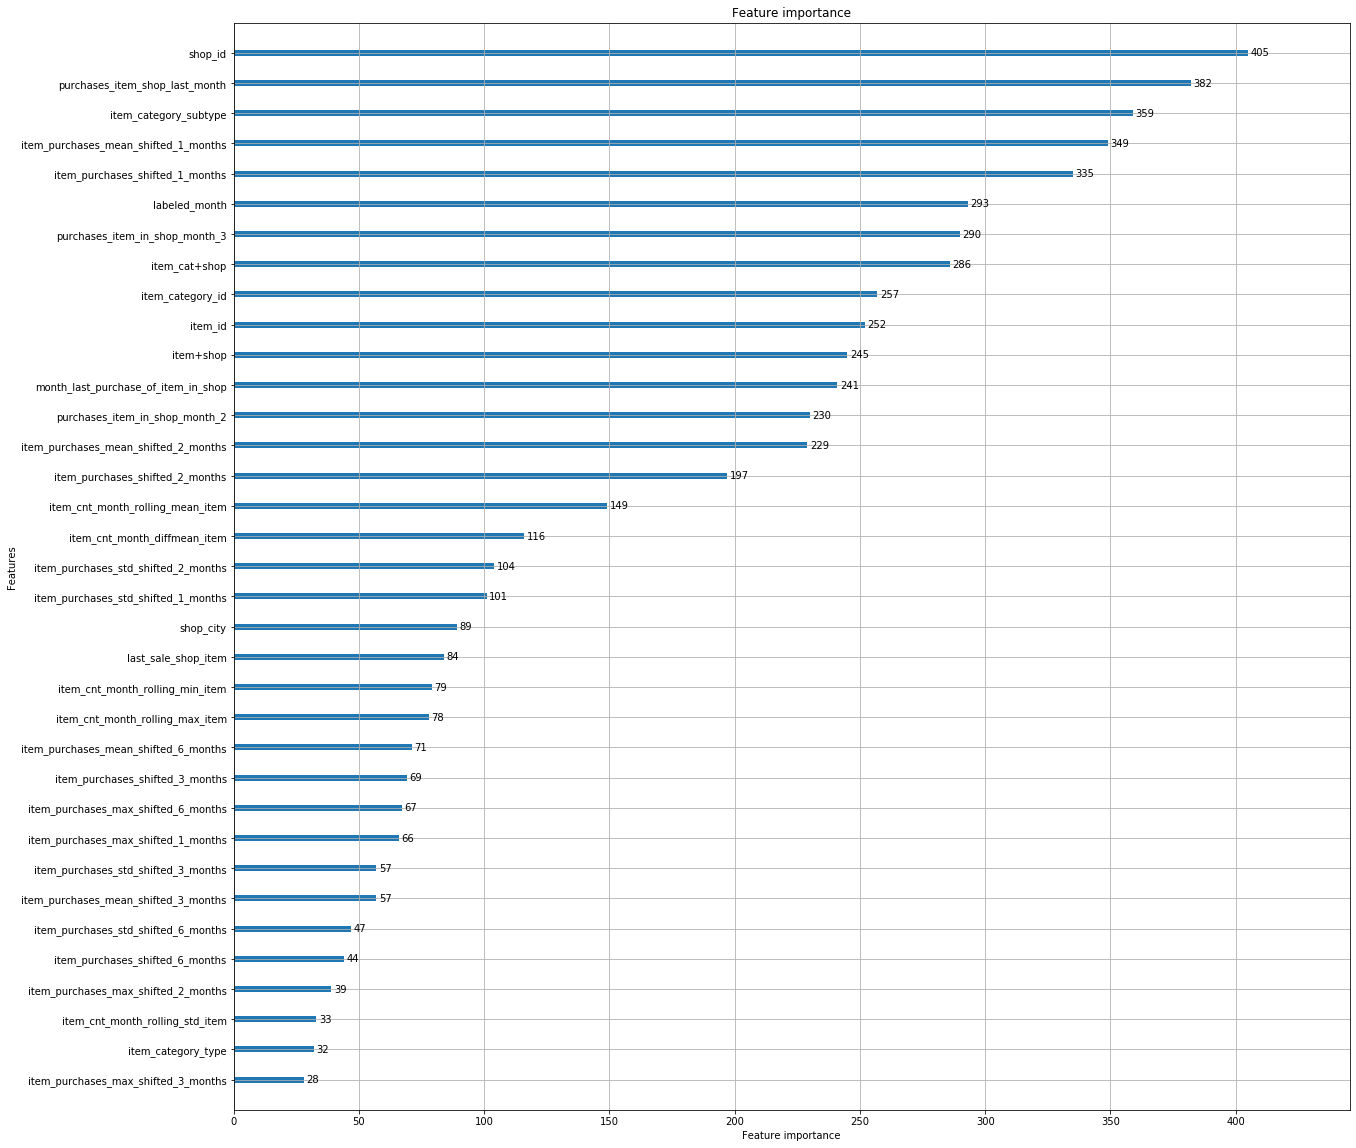

In [53]:
plot_importance(lgbm, max_num_features=75, figsize=(20,20))

In [54]:
X_test["item_cnt_month"] = lgbm.predict(X_test).clip(0, 20)

## CATBOOST

In [44]:
train_pool = Pool(X_train, y_train)

In [45]:
catboost = CatBoostRegressor(iterations=2000, 
                      depth=10, 
                      learning_rate=0.01, 
                      loss_function='RMSE',
                      random_state=27)                        

In [ ]:
catboost.fit(train_pool, eval_set=Pool(X_val, y_val))

In [47]:
predictions_train = catboost.predict(X_train)

root_mean_squared_error(y_train, predictions_train)

0.623826501146062

In [48]:
predictions = catboost.predict(X_val)

root_mean_squared_error(y_val, predictions)

0.6504081288304769

In [49]:
jb.dump(catboost, "new-models/CB3.pkl")

['new-models/CB3.pkl']

## RANDOM FOREST

In [64]:
regressor = RandomForestRegressor(n_jobs=-1, random_state=27, criterion="mse", n_estimators=800, max_features='auto', max_depth=7, min_samples_split=2, min_samples_leaf=4)

In [ ]:
regressor.fit(X_train, y_train)

In [ ]:
predictions_train = regressor.predict(X_train)

root_mean_squared_error(y_train, predictions_train)

In [ ]:
predictions = regressor.predict(X_test)

root_mean_squared_error(y_test, predictions)

In [ ]:
jb.dump(regressor, "new-models/RF1.pkl")

## STACKING

In [ ]:
xgb_parameters = jb.load("model_parameters/xgb_parameters.pkl")

In [ ]:
xgboost = XGBRegressor(
 learning_rate=0.01,
 n_estimators=2000,
 max_depth=xgb_parameters["max_depth"],
 min_child_weight=xgb_parameters["min_child_weight"],
 gamma=xgb_parameters["gamma"],
 subsample=xgb_parameters["subsample"],
 colsample_bytree=xgb_parameters["colsample_by_tree"],
 objective='reg:squarederror',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

random_forest = RandomForestRegressor(n_jobs=-1,
                                     random_state=27,
                                     criterion="mse",
                                     n_estimators=800,
                                     max_features='auto',
                                     max_depth=7,
                                     min_samples_split=2,
                                     min_samples_leaf=4)

lgbm = LGBMRegressor(
 learning_rate=0.01,
 n_estimators=2000,
 max_depth=6,
 boosting_type='gbdt' ,
 subsample=0.9,
 objective='regression',
 colsample_bytree=0.7,
 min_child_weight=1,   
 njobs=4,
 scale_pos_weight=1,   
 random_state=27,
 silent=False)

catboost = CatBoostRegressor(iterations=2000, 
                      depth=7, 
                      learning_rate=0.01, 
                      loss_function='RMSE',
                      random_state=27)  

estimators = [('xgb', xgboost), ('lgbm', lgbm), ('rf', random_forest), ('cb', catboost)]

In [ ]:
features = df

target_col = "label"
predictors = [x for x in features.columns if x != target_col]

jb.dump(predictors, "model_parameters/stacking_reg.pkl")

predictors

In [ ]:
linear_reg = LinearRegression()

In [ ]:
X = features[predictors]
y = features[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

In [ ]:
stacking_regressor = StackingRegressor(
        estimators=estimators,
        final_estimator=linear_reg,
        n_jobs=-1
)

In [ ]:
stacking_regressor.fit(X_train, y_train)

In [ ]:
predictions_train = stacking_regressor.predict(X_train)

root_mean_squared_error(y_train, predictions_train)

In [ ]:
predictions = stacking_regressor.predict(X_test)

root_mean_squared_error(y_test, predictions)

In [ ]:
jb.dump(stacking_regressor, 'new-models/SR7.pkl')

# Generate submission

In [38]:
test = pd.read_csv("cleaned_data/test.csv")
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [39]:
test = test.merge(X_test, on=["item_id", "shop_id"], how="inner")
test = test[["ID", "item_cnt_month"]]

In [40]:
test["item_cnt_month"].mean()

0.2894894480705261

In [42]:
test.to_csv("submissions/236-XGB29.csv", index=False)

# MERGE TWO PREDICTIONS FOR DIFFERENT MODELS

In [59]:
sub_1 = pd.read_csv("submissions/233-XGB28.csv")
sub_2 = pd.read_csv("submissions/234-LGBM64.csv")

In [60]:
def merge_predictions_for_two_models(df_1, df_2):
    df = pd.merge(df_1, df_2, on="ID", how="inner")
    df["item_cnt_month"] = df["item_cnt_month_x"] * 0.5 + df["item_cnt_month_y"] * 0.5
    df.drop(columns=["item_cnt_month_x", "item_cnt_month_y"], inplace=True)
    df.sort_values(by="ID", inplace=True)
    return df

In [61]:
sub = merge_predictions_for_two_models(sub_1, sub_2)

In [62]:
sub["item_cnt_month"].mean()

0.2755069226347226

In [63]:
sub.to_csv("submissions/235-XGB28-LGBM64.csv", index=False)